In [2]:
import os
import glob
import wfdb
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1658497162847124986)

data_directory = "./data/CEBS/m001"
model_directory = './models/'
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_dbs = [-1, 0.5, 2, 10]

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

#num_epochs = 1024
#batch_size = 64
#learning_rate = 0.001
#weight_decay = 0.01

In [4]:
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

def psnr(signal_clean, signal_noisy):
    return 20 * np.log10(np.max(signal_clean) / (np.sum((signal_noisy - signal_clean) ** 2)))

def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_noisy - signal_clean) ** 2) / np.sum(signal_clean ** 2)) * 100

def xcorr(signal_clean, signal_noisy):
    return np.correlate(signal_clean, signal_noisy, mode='same')

In [5]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    frequency = metadata['fs']
    column_names = metadata['sig_name']
    length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)
    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples)]
    data = data.apply(lambda x: np.array(x))
    
    return data

In [6]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*m[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    return data

In [7]:
# https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

def add_gaussian(data, target_snr_dbs):

    target_snr_db = random.choice(target_snr_dbs)

    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = np.mean(data)
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

def normalize(x, min_val, max_val):
    y = (x-min_val) / (max_val - min_val)
    return y

In [8]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        self.min_val = 0
        self.max_val = np.inf

        data = load_datasets('./data/CEBS/')
        #data = data.resample(sampling_rate).mean().SCG

        #data_noisy = add_gaussian(data, target_snr_db)
        data_noise = data.apply(lambda x: add_gaussian(x, target_snr_dbs)) # maybe randomly apply different noise levels to parts of data --> generalization, maybe prove this with experiment
        data = pd.DataFrame({'clean': data, 'noise': data_noise})

        #data_concat = np.concatenate([np.concatenate(data.values[0]), np.concatenate(data.values[1])])
        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        self.min_val = np.min(data.values.tolist())
        self.max_val = np.max(data.values.tolist())

        for column in data.columns:
            data[column] = data[column].apply(lambda x: normalize(x, self.min_val, self.max_val))
            # data[column] = (data[column] - self.min_val) / (self.max_val - self.min_val)

        for idx, row in data.iterrows():
            print(snr(reverse2(row[0], self.min_val, self.max_val), reverse2(row[1], self.min_val, self.max_val)))
            print(snr(row[0], row[1]))
        print(self.max_val)
        print(self.min_val)
        #data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        #data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        #data['clean'] = data['clean'].apply(lambda x: np.array(x))
        #data['noise'] = data['noise'].apply(lambda x: np.array(x))
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [9]:
def reverse2(x, min_val, max_val):
    return max_val * x - x * min_val + min_val

dataset = SCGData(transform=ToTensor())

-0.9250919143426627
54.662962499827586
1.9732173595291411
57.88860349790505
-0.950116575891232
55.457799748616864
-1.0183012534544778
54.192605021559615
1.7745879798714266
57.81463414060422
2.17694175056136
58.073465085672
-1.016142782111948
55.3242590294743
9.794848543282937
65.19710551326574
-1.3025763198223792
55.40250999760762
1.8329533878104671
59.273979568462124
0.8063273744865557
57.34015841467528
9.942792168128815
66.01277835564174
9.966413968086066
66.68433612085298
9.908723901393818
66.00391067042003
0.528830876273835
56.77080753681281
9.534799155105473
67.8338515637596
2.0621855426976756
58.09827553813725
10.24527353312818
66.83383373080895
1.9773644994825887
58.88096562259044
0.38018008286521016
57.92616334702029
2.107543177467566
58.551279879882316
0.6798869937580683
54.933624256375055
2.005341603853979
57.50437970175754
2.122503337406053
58.166198914905124
9.850763137359348
66.71964350953262
-1.0024494511918538
53.42290595976041
-0.98275626448617
55.44632320804713
9.88371

In [10]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [51]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 16, stride=2),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/2), 16, stride=2),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 16, stride=2),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 16, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 16, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 16, stride=2, output_padding=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), layer_size, 16, stride=2, output_padding=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.ConvTranspose1d(layer_size, 1, 16, stride=2, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 16, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise1(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise1                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 100]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 505]
│    └─BatchNorm1d: 2-2                  [32, 128, 505]            [32, 128, 505]
│    └─ELU: 2-3                          [32, 128, 505]            [32, 128, 505]
│    └─Conv1d: 2-4                       [32, 128, 505]            [32, 64, 245]
│    └─BatchNorm1d: 2-5                  [32, 64, 245]             [32, 64, 245]
│    └─ELU: 2-6                          [32, 64, 245]             [32, 64, 245]
│    └─Conv1d: 2-7                       [32, 64, 245]             [32, 32, 115]
│    └─BatchNorm1d: 2-8                  [32, 32, 115]             [32, 32, 115]
│    └─ELU: 2-9                          [32, 32, 115]             [32, 32, 115]
│    └─Conv1d: 2-10        

In [12]:
class DeNoise2(nn.Module):
    def __init__(self, kernel_size=16, filters_1=64, filters_2=32):
        super(DeNoise2, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded


print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*16) + 7)
torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
39.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 3]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 64, 505]
│    └─BatchNorm1d: 2-2                  [32, 64, 505]             [32, 64, 505]
│    └─ELU: 2-3                          [32, 64, 505]             [32, 64, 505]
│    └─Conv1d: 2-4                       [32, 64, 505]             [32, 32, 245]
│    └─BatchNorm1d: 2-5                  [32, 32, 245]             [32, 32, 245]
│    └─ELU: 2-6                          [32, 32, 245]             [32, 32, 245]
│    └─Conv1d: 2-7                       [32, 32, 245]             [32, 32, 115]
│    └─BatchNorm1d: 2-8                  [32, 32, 115]             [32, 32, 115]
│    └─ELU: 2-9                          [32, 32, 115]             [32, 32, 115]
│    └─Conv1d: 2-10             

In [13]:
class DeNoiseNone(nn.Module):
    def __init__(self):
        super(DeNoiseNone, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

torchinfo.summary(DeNoise2(), (64, 1, 1024), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [64, 1, 1024]             [64, 1, 1024]
├─Sequential: 1-1                        [64, 1, 1024]             [64, 1, 3]
│    └─Conv1d: 2-1                       [64, 1, 1024]             [64, 64, 505]
│    └─BatchNorm1d: 2-2                  [64, 64, 505]             [64, 64, 505]
│    └─ELU: 2-3                          [64, 64, 505]             [64, 64, 505]
│    └─Conv1d: 2-4                       [64, 64, 505]             [64, 32, 245]
│    └─BatchNorm1d: 2-5                  [64, 32, 245]             [64, 32, 245]
│    └─ELU: 2-6                          [64, 32, 245]             [64, 32, 245]
│    └─Conv1d: 2-7                       [64, 32, 245]             [64, 32, 115]
│    └─BatchNorm1d: 2-8                  [64, 32, 115]             [64, 32, 115]
│    └─ELU: 2-9                          [64, 32, 115]             [64, 32, 115]
│    └─Conv1d: 2-10             

In [46]:
def train(config, train_dataset, model_num, is_tune=False, checkpoint_dir=None, data_dir=None):

    if model_num == 1:
        model = DeNoise1(layer_size=config['layer_size'])
    else:
        model = DeNoise2(filters_1=config['layer_size'], filters_2=int(config['layer_size']/2))
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.99), weight_decay=config['wd'])

    if checkpoint_dir != None:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

            #if (i + 1) % 50 == 0:
            #    print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1} / {n_total_steps}, loss = {loss.item():.10f}')
        train_loss_values.append(train_loss)

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            #_, predicted = torch.max(output.data, 1)
            #total += lables.size(0)
            #correct += (predicted == lables).sum().item()

            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1
        val_loss_values.append(val_loss)

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss

                if model_num == 1:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_1.pth'))
                else:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_2.pth'))

                df = pd.DataFrame({'train_loss': train_loss_values, 'val_loss': val_loss_values})
                df.to_csv('./models/loss_1.csv')    

In [15]:
train_dataset, test_dataset = load_data()

In [47]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

num_samples = 64 # sample data multiple times
max_num_epochs = 512

config = {
    'lr': tune.loguniform(1e-5, 1e-3),
    'wd': 0,
    'batch_size': tune.choice([8]),
    'layer_size': tune.choice([128])
}

scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
result = tune.run(
    partial(train, train_dataset=train_dataset, model_num=1, is_tune=True, checkpoint_dir=None, data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
# print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

best_trained_model =  DeNoise2().to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
#best_trained_model.load_state_dict(model_state)

2022-11-07 19:57:26,318	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (89 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-11-07 19:57:27,301	WARNING util.py:220 -- The `start_trial` operation took 1.666 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-07 19:57:27 (running for 00:00:13.51)
Memory usage on this node: 8.2/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 16/64 (15 PENDING, 1 RUNNING)
+-------------------+----------+-----------------------+--------------+--------------+-------------+
| Trial name        | status   | loc                   |   batch_size |   layer_size |          lr |
|-------------------+----------+-----------------------+--------------+--------------+-------------|
| train_fdd13_00000 | RUNNING  | 192.168.178.25:410162 |           32 |          128 | 1.20086e-05 |
| train_fdd13_

(func pid=410162) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=410162)   return F.conv1d(input, weight, bias, self.stride,


Result for train_fdd13_00000:
  date: 2022-11-07_19-57-33
  done: false
  experiment_id: 5d7f773529424a938dd9d83f3af7a8bc
  hostname: pop-os
  iterations_since_restore: 1
  loss: 0.6883185177013792
  node_ip: 192.168.178.25
  pid: 410162
  should_checkpoint: true
  time_since_restore: 4.163760662078857
  time_this_iter_s: 4.163760662078857
  time_total_s: 4.163760662078857
  timestamp: 1667847453
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fdd13_00000
  warmup_time: 0.0020401477813720703
  
== Status ==
Current time: 2022-11-07 19:57:33 (running for 00:00:19.61)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6883185177013792
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)

2022-11-07 20:02:01,427	WARNING util.py:220 -- The `start_trial` operation took 0.531 s, which may be a performance bottleneck.
(func pid=414831) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=414831)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:02:07 (running for 00:04:53.40)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.30330918575155325 | Iter 32.000: -0.446394379796653 | Iter 16.000: -0.4953352192352558 | Iter 8.000: -0.5315636149768171 | Iter 4.000: -0.5723909324613111 | Iter 2.000: -0.62687539026655 | Iter 1.000: -0.6883185177013792
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 18/64 (16 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+----------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |     loss |   training_iteration |
|-------------------+------

(func pid=419486) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=419486)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:06:35 (running for 00:09:21.43)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.1518791162460071 | Iter 32.000: -0.2238799310209037 | Iter 16.000: -0.25446060548761285 | Iter 8.000: -0.2802926061418036 | Iter 4.000: -0.3073060408491513 | Iter 2.000: -0.34114241567922055 | Iter 1.000: -0.38256833316950967
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 19/64 (16 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-----------------

2022-11-07 20:15:11,506	WARNING util.py:220 -- The `start_trial` operation took 0.502 s, which may be a performance bottleneck.
(func pid=424245) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=424245)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:15:17 (running for 00:18:03.48)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.0004490467404609482 | Iter 32.000: -0.0013654822451544218 | Iter 16.000: -0.013585991739969829 | Iter 8.000: -0.029021597306790024 | Iter 4.000: -0.04222114923699149 | Iter 2.000: -0.07945247045878706 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 20/64 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-----

(func pid=424326) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=424326)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:15:26 (running for 00:18:12.47)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.0004490467404609482 | Iter 32.000: -0.0013654822451544218 | Iter 16.000: -0.013585991739969829 | Iter 8.000: -0.029021597306790024 | Iter 4.000: -0.04222114923699149 | Iter 2.000: -0.07945247045878706 | Iter 1.000: -0.1764876251590663
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 21/64 (16 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|------

2022-11-07 20:15:31,540	WARNING util.py:220 -- The `start_trial` operation took 0.503 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-07 20:15:31 (running for 00:18:17.74)
Memory usage on this node: 8.1/15.6 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.0004490467404609482 | Iter 32.000: -0.0013654822451544218 | Iter 16.000: -0.013585991739969829 | Iter 8.000: -0.029021597306790024 | Iter 4.000: -0.04222114923699149 | Iter 2.000: -0.07945247045878706 | Iter 1.000: -0.22969705817000619
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 21/64 (15 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-----

(func pid=424407) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=424407)   return F.conv1d(input, weight, bias, self.stride,


Result for train_fdd13_00005:
  date: 2022-11-07_20-15-37
  done: true
  experiment_id: 399197324604462085b6b380e1ad72fd
  hostname: pop-os
  iterations_since_restore: 1
  loss: 0.2515911490752779
  node_ip: 192.168.178.25
  pid: 424407
  should_checkpoint: true
  time_since_restore: 4.142555475234985
  time_this_iter_s: 4.142555475234985
  time_total_s: 4.142555475234985
  timestamp: 1667848537
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fdd13_00005
  warmup_time: 0.0021224021911621094
  
== Status ==
Current time: 2022-11-07 20:15:37 (running for 00:18:23.90)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.0004490467404609482 | Iter 32.000: -0.0013654822451544218 | Iter 16.000: -0.013585991739969829 | Iter 8.000: -0.029021597306790024 | Iter 4.000: -0.04222114923699149 | Iter 2.000: -0.07945247045878706 | Iter 1.000: -0.24064410362264205
Resources r

(func pid=424489) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=424489)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:15:44 (running for 00:18:30.50)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.0004490467404609482 | Iter 32.000: -0.0013654822451544218 | Iter 16.000: -0.013585991739969829 | Iter 8.000: -0.029021597306790024 | Iter 4.000: -0.04222114923699149 | Iter 2.000: -0.07945247045878706 | Iter 1.000: -0.24064410362264205
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 23/64 (16 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-----

2022-11-07 20:15:47,561	WARNING util.py:220 -- The `start_trial` operation took 0.501 s, which may be a performance bottleneck.
(func pid=424570) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=424570)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:15:53 (running for 00:18:39.51)
Memory usage on this node: 9.7/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.0004490467404609482 | Iter 32.000: -0.0013654822451544218 | Iter 16.000: -0.013585991739969829 | Iter 8.000: -0.029021597306790024 | Iter 4.000: -0.04222114923699149 | Iter 2.000: -0.07945247045878706 | Iter 1.000: -0.25140805080019196
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 24/64 (16 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-----

(func pid=429275) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=429275)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:24:40 (running for 00:27:26.64)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -0.00023241237548863238 | Iter 32.000: -0.0007073387627440689 | Iter 16.000: -0.0068840127235583574 | Iter 8.000: -0.014846084637422886 | Iter 4.000: -0.03475557871419808 | Iter 2.000: -0.06743095577533903 | Iter 1.000: -0.24055255448509907
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 25/64 (16 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|---

2022-11-07 20:33:16,747	WARNING util.py:220 -- The `start_trial` operation took 0.528 s, which may be a performance bottleneck.
(func pid=434015) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=434015)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:33:22 (running for 00:36:08.72)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -2.119633585732964e-05 | Iter 32.000: -4.919528033371597e-05 | Iter 16.000: -0.0001820337071468861 | Iter 8.000: -0.0006705719680557477 | Iter 4.000: -0.02729000819140467 | Iter 2.000: -0.05540944109189099 | Iter 1.000: -0.22969705817000619
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 26/64 (16 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|---

2022-11-07 20:33:25,722	WARNING util.py:220 -- The `start_trial` operation took 0.501 s, which may be a performance bottleneck.
(func pid=434096) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=434096)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:33:31 (running for 00:36:17.74)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -2.119633585732964e-05 | Iter 32.000: -4.919528033371597e-05 | Iter 16.000: -0.0001820337071468861 | Iter 8.000: -0.0006705719680557477 | Iter 4.000: -0.02729000819140467 | Iter 2.000: -0.05540944109189099 | Iter 1.000: -0.24055255448509907
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 27/64 (16 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|--

(func pid=434235) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=434235)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:33:56 (running for 00:36:42.72)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -2.119633585732964e-05 | Iter 32.000: -4.919528033371597e-05 | Iter 16.000: -0.0001820337071468861 | Iter 8.000: -0.0006705719680557477 | Iter 4.000: -0.02729000819140467 | Iter 2.000: -0.06304257119010234 | Iter 1.000: -0.22969705817000619
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 28/64 (16 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|--

2022-11-07 20:33:59,745	WARNING util.py:220 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.
(func pid=434320) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=434320)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:34:05 (running for 00:36:51.72)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -2.119633585732964e-05 | Iter 32.000: -4.919528033371597e-05 | Iter 16.000: -0.0001820337071468861 | Iter 8.000: -0.0006705719680557477 | Iter 4.000: -0.02729000819140467 | Iter 2.000: -0.06304257119010234 | Iter 1.000: -0.24055255448509907
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 29/64 (16 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|--

2022-11-07 20:34:09,753	WARNING util.py:220 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.
(func pid=434409) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=434409)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:34:15 (running for 00:37:01.73)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -2.119633585732964e-05 | Iter 32.000: -4.919528033371597e-05 | Iter 16.000: -0.0001820337071468861 | Iter 8.000: -0.0006705719680557477 | Iter 4.000: -0.02729000819140467 | Iter 2.000: -0.06304257119010234 | Iter 1.000: -0.25140805080019196
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 30/64 (16 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|--

(func pid=434535) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=434535)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:34:25 (running for 00:37:12.02)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -2.119633585732964e-05 | Iter 32.000: -4.919528033371597e-05 | Iter 16.000: -0.0001820337071468861 | Iter 8.000: -0.0006705719680557477 | Iter 4.000: -0.02729000819140467 | Iter 2.000: -0.0706757012883137 | Iter 1.000: -0.24055255448509907
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 31/64 (16 PENDING, 1 RUNNING, 14 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|---

2022-11-07 20:45:53,830	WARNING util.py:220 -- The `start_trial` operation took 0.507 s, which may be a performance bottleneck.
(func pid=439327) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=439327)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:45:59 (running for 00:48:45.79)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -1.84871731868231e-05 | Iter 32.000: -4.372086522349052e-05 | Iter 16.000: -0.00014869280770152068 | Iter 8.000: -0.0005631185275229529 | Iter 4.000: -0.014457513923467747 | Iter 2.000: -0.06304257119010234 | Iter 1.000: -0.22969705817000619
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 32/64 (16 PENDING, 1 RUNNING, 15 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-

2022-11-07 20:53:50,931	WARNING util.py:220 -- The `start_trial` operation took 0.520 s, which may be a performance bottleneck.
(func pid=444058) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=444058)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 20:53:56 (running for 00:56:42.90)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -1.577801051631656e-05 | Iter 32.000: -3.8246450113265067e-05 | Iter 16.000: -0.00011535190825615528 | Iter 8.000: -0.0004556650869901581 | Iter 4.000: -0.0016250196555308227 | Iter 2.000: -0.05540944109189099 | Iter 1.000: -0.2071078102393397
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 33/64 (16 PENDING, 1 RUNNING, 16 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |


2022-11-07 21:11:07,093	WARNING util.py:220 -- The `start_trial` operation took 0.511 s, which may be a performance bottleneck.
(func pid=448935) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=448935)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:11:12 (running for 01:13:59.05)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -1.2836982098610076e-05 | Iter 32.000: -3.444682759687441e-05 | Iter 16.000: -8.154201711069368e-05 | Iter 8.000: -0.00031540889189084827 | Iter 4.000: -0.0015774848168426804 | Iter 2.000: -0.032990503365752 | Iter 1.000: -0.1845185623086732
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 34/64 (16 PENDING, 1 RUNNING, 17 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-

2022-11-07 21:19:00,182	WARNING util.py:220 -- The `start_trial` operation took 0.504 s, which may be a performance bottleneck.
(func pid=453713) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=453713)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:19:05 (running for 01:21:52.19)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.895953680903592e-06 | Iter 32.000: -3.064720508048375e-05 | Iter 16.000: -4.773212596523206e-05 | Iter 8.000: -0.0001751526967915385 | Iter 4.000: -0.001529949978154538 | Iter 2.000: -0.010571565639613003 | Iter 1.000: -0.1538983772283998
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 35/64 (16 PENDING, 1 RUNNING, 18 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-

2022-11-07 21:19:25,196	WARNING util.py:220 -- The `start_trial` operation took 0.514 s, which may be a performance bottleneck.
(func pid=453853) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=453853)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:19:30 (running for 01:22:17.17)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.895953680903592e-06 | Iter 32.000: -3.064720508048375e-05 | Iter 16.000: -4.773212596523206e-05 | Iter 8.000: -0.0001751526967915385 | Iter 4.000: -0.001529949978154538 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 36/64 (16 PENDING, 1 RUNNING, 19 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|

2022-11-07 21:19:32,197	WARNING util.py:220 -- The `start_trial` operation took 0.512 s, which may be a performance bottleneck.
(func pid=453935) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=453935)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:19:37 (running for 01:22:24.19)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.895953680903592e-06 | Iter 32.000: -3.064720508048375e-05 | Iter 16.000: -4.773212596523206e-05 | Iter 8.000: -0.0001751526967915385 | Iter 4.000: -0.001529949978154538 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.1538983772283998
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 37/64 (16 PENDING, 1 RUNNING, 20 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-

2022-11-07 21:19:39,206	WARNING util.py:220 -- The `start_trial` operation took 0.523 s, which may be a performance bottleneck.
(func pid=454015) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=454015)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:19:45 (running for 01:22:31.22)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.895953680903592e-06 | Iter 32.000: -3.064720508048375e-05 | Iter 16.000: -4.773212596523206e-05 | Iter 8.000: -0.0001751526967915385 | Iter 4.000: -0.001529949978154538 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.1845185623086732
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 38/64 (16 PENDING, 1 RUNNING, 21 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-

2022-11-07 21:19:46,212	WARNING util.py:220 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.
(func pid=454102) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=454102)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:19:52 (running for 01:22:38.23)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.895953680903592e-06 | Iter 32.000: -3.064720508048375e-05 | Iter 16.000: -4.773212596523206e-05 | Iter 8.000: -0.0001751526967915385 | Iter 4.000: -0.001529949978154538 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.19880542672913648
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 39/64 (16 PENDING, 1 RUNNING, 22 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|

2022-11-07 21:37:04,392	WARNING util.py:220 -- The `start_trial` operation took 0.567 s, which may be a performance bottleneck.
(func pid=459028) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=459028)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:37:10 (running for 01:39:56.39)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.532086332636277e-06 | Iter 32.000: -2.3808803846271796e-05 | Iter 16.000: -3.363164201518571e-05 | Iter 8.000: -0.00013335139650233282 | Iter 4.000: -0.001073254138112855 | Iter 2.000: -0.010571565639613003 | Iter 1.000: -0.1845185623086732
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 40/64 (16 PENDING, 1 RUNNING, 23 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |

2022-11-07 21:37:15,342	WARNING util.py:220 -- The `start_trial` operation took 0.516 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-07 21:37:15 (running for 01:40:01.54)
Memory usage on this node: 8.3/15.6 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.532086332636277e-06 | Iter 32.000: -2.3808803846271796e-05 | Iter 16.000: -3.363164201518571e-05 | Iter 8.000: -0.00013335139650233282 | Iter 4.000: -0.001073254138112855 | Iter 2.000: -0.010571565639613003 | Iter 1.000: -0.19880542672913648
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 40/64 (15 PENDING, 1 RUNNING, 24 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration 

(func pid=459109) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=459109)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:37:23 (running for 01:40:09.49)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.532086332636277e-06 | Iter 32.000: -2.3808803846271796e-05 | Iter 16.000: -3.363164201518571e-05 | Iter 8.000: -0.00013335139650233282 | Iter 4.000: -0.001073254138112855 | Iter 2.000: -0.010571565639613003 | Iter 1.000: -0.19880542672913648
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 41/64 (16 PENDING, 1 RUNNING, 24 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

2022-11-07 21:37:30,360	WARNING util.py:220 -- The `start_trial` operation took 0.532 s, which may be a performance bottleneck.
(func pid=459236) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=459236)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:37:36 (running for 01:40:22.39)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.532086332636277e-06 | Iter 32.000: -2.3808803846271796e-05 | Iter 16.000: -3.363164201518571e-05 | Iter 8.000: -0.00013335139650233282 | Iter 4.000: -0.001073254138112855 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.1845185623086732
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 42/64 (16 PENDING, 1 RUNNING, 25 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |


2022-11-07 21:37:39,376	WARNING util.py:220 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.
(func pid=459317) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=459317)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:37:45 (running for 01:40:31.41)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.532086332636277e-06 | Iter 32.000: -2.3808803846271796e-05 | Iter 16.000: -3.363164201518571e-05 | Iter 8.000: -0.00013335139650233282 | Iter 4.000: -0.001073254138112855 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.19880542672913648
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 43/64 (16 PENDING, 1 RUNNING, 26 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration 

2022-11-07 21:37:54,389	WARNING util.py:220 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.
(func pid=459444) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=459444)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:38:00 (running for 01:40:46.51)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.532086332636277e-06 | Iter 32.000: -2.3808803846271796e-05 | Iter 16.000: -3.363164201518571e-05 | Iter 8.000: -0.00013335139650233282 | Iter 4.000: -0.001073254138112855 | Iter 2.000: -0.01877514211910552 | Iter 1.000: -0.1845185623086732
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 44/64 (16 PENDING, 1 RUNNING, 27 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |

2022-11-07 21:44:52,476	WARNING util.py:220 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.
(func pid=464236) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=464236)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:44:58 (running for 01:47:44.48)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.168218984368964e-06 | Iter 32.000: -1.6970402612059843e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -9.155009621312714e-05 | Iter 4.000: -0.0006165582980711719 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.184485769991217
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 45/64 (16 PENDING, 1 RUNNING, 28 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |


2022-11-07 21:45:06,397	WARNING util.py:220 -- The `start_trial` operation took 0.504 s, which may be a performance bottleneck.
(func pid=464363) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=464363)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:45:12 (running for 01:47:58.38)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.168218984368964e-06 | Iter 32.000: -1.6970402612059843e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -9.155009621312714e-05 | Iter 4.000: -0.0006165582980711719 | Iter 2.000: -0.01877514211910552 | Iter 1.000: -0.1844529776737608
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 46/64 (16 PENDING, 1 RUNNING, 29 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration 

2022-11-07 21:47:01,447	WARNING util.py:220 -- The `start_trial` operation took 0.509 s, which may be a performance bottleneck.
(func pid=465168) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=465168)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:47:07 (running for 01:49:53.52)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.168218984368964e-06 | Iter 32.000: -1.6970402612059843e-05 | Iter 16.000: -2.9093628048084128e-05 | Iter 8.000: -7.849036300567919e-05 | Iter 4.000: -0.0004089961449639743 | Iter 2.000: -0.01467335387935926 | Iter 1.000: -0.1538655849109436
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 47/64 (16 PENDING, 1 RUNNING, 30 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |

2022-11-07 21:53:56,504	WARNING util.py:220 -- The `start_trial` operation took 0.506 s, which may be a performance bottleneck.
(func pid=469897) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=469897)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:54:02 (running for 01:56:48.54)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -6.543062979823123e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.010571565639613003 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 48/64 (16 PENDING, 1 RUNNING, 31 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration 

(func pid=470132) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=470132)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:54:48 (running for 01:57:34.58)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -6.543062979823123e-05 | Iter 4.000: -0.0004089961449639743 | Iter 2.000: -0.01044535490780555 | Iter 1.000: -0.11670345543273564
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 49/64 (16 PENDING, 1 RUNNING, 32 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration 

2022-11-07 21:54:53,521	WARNING util.py:220 -- The `start_trial` operation took 0.516 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-07 21:54:53 (running for 01:57:39.72)
Memory usage on this node: 8.3/15.6 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -6.543062979823123e-05 | Iter 4.000: -0.0004089961449639743 | Iter 2.000: -0.01044535490780555 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 49/64 (15 PENDING, 1 RUNNING, 33 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |

(func pid=470213) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=470213)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:55:01 (running for 01:57:47.61)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -6.543062979823123e-05 | Iter 4.000: -0.0004089961449639743 | Iter 2.000: -0.01044535490780555 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 50/64 (16 PENDING, 1 RUNNING, 33 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |

2022-11-07 21:56:48,536	WARNING util.py:220 -- The `start_trial` operation took 0.515 s, which may be a performance bottleneck.
(func pid=470998) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=470998)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:56:54 (running for 01:59:40.61)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -2.0149637565078467e-05 | Iter 8.000: -5.758887901888018e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.010319144175998095 | Iter 1.000: -0.11670345543273564
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 51/64 (16 PENDING, 1 RUNNING, 34 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

2022-11-07 21:57:03,548	WARNING util.py:220 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.
(func pid=471080) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=471080)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:57:09 (running for 01:59:55.56)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -2.0149637565078467e-05 | Iter 8.000: -5.758887901888018e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.010319144175998095 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 52/64 (16 PENDING, 1 RUNNING, 35 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

2022-11-07 21:57:28,541	WARNING util.py:220 -- The `start_trial` operation took 0.514 s, which may be a performance bottleneck.
(func pid=471210) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=471210)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:57:34 (running for 02:00:20.89)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -2.0149637565078467e-05 | Iter 8.000: -5.758887901888018e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.01044535490780555 | Iter 1.000: -0.11670345543273564
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 53/64 (16 PENDING, 1 RUNNING, 36 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration 

2022-11-07 21:57:37,542	WARNING util.py:220 -- The `start_trial` operation took 0.514 s, which may be a performance bottleneck.
(func pid=471291) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=471291)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:57:43 (running for 02:00:29.57)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -2.0149637565078467e-05 | Iter 8.000: -5.758887901888018e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.01044535490780555 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 54/64 (16 PENDING, 1 RUNNING, 37 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration 

2022-11-07 21:57:47,553	WARNING util.py:220 -- The `start_trial` operation took 0.523 s, which may be a performance bottleneck.
(func pid=471372) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=471372)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:57:53 (running for 02:00:39.61)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -2.0149637565078467e-05 | Iter 8.000: -5.758887901888018e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.01044535490780555 | Iter 1.000: -0.1538655849109436
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 55/64 (16 PENDING, 1 RUNNING, 38 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |

2022-11-07 21:58:10,545	WARNING util.py:220 -- The `start_trial` operation took 0.512 s, which may be a performance bottleneck.
(func pid=471590) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=471590)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 21:58:16 (running for 02:01:02.56)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.409560301540139e-05 | Iter 16.000: -2.0149637565078467e-05 | Iter 8.000: -5.758887901888018e-05 | Iter 4.000: -0.00038044120948801843 | Iter 2.000: -0.010319144175998095 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 56/64 (16 PENDING, 1 RUNNING, 39 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

2022-11-07 22:02:35,597	WARNING util.py:220 -- The `start_trial` operation took 0.527 s, which may be a performance bottleneck.
(func pid=474642) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=474642)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:02:41 (running for 02:05:27.59)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.168218984368964e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -4.974712823952913e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.007524266662397261 | Iter 1.000: -0.11670345543273564
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 57/64 (16 PENDING, 1 RUNNING, 40 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteratio

(func pid=474723) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=474723)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:02:50 (running for 02:05:36.55)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.168218984368964e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -4.974712823952913e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.007524266662397261 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 58/64 (16 PENDING, 1 RUNNING, 41 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteratio

(func pid=474804) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=474804)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:02:59 (running for 02:05:45.56)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -9.168218984368964e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.9531158065139357e-05 | Iter 8.000: -4.974712823952913e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.007524266662397261 | Iter 1.000: -0.1538655849109436
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 59/64 (16 PENDING, 1 RUNNING, 42 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

2022-11-07 22:14:30,767	WARNING util.py:220 -- The `start_trial` operation took 0.591 s, which may be a performance bottleneck.
(func pid=479621) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=479621)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:14:36 (running for 02:17:22.79)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.00016616769582846058 | Iter 2.000: -0.004729389148796427 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 60/64 (16 PENDING, 1 RUNNING, 43 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterat

(func pid=479703) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=479703)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:14:51 (running for 02:17:37.71)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.00016616769582846058 | Iter 2.000: -0.004729389148796427 | Iter 1.000: -0.1538655849109436
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 61/64 (16 PENDING, 1 RUNNING, 44 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterati

2022-11-07 22:15:00,682	WARNING util.py:220 -- The `start_trial` operation took 0.501 s, which may be a performance bottleneck.
(func pid=479934) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=479934)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:15:06 (running for 02:17:52.73)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0031107883902411135 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 62/64 (16 PENDING, 1 RUNNING, 45 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterati

2022-11-07 22:15:10,699	WARNING util.py:220 -- The `start_trial` operation took 0.516 s, which may be a performance bottleneck.
(func pid=480023) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=480023)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:15:16 (running for 02:18:02.75)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0031107883902411135 | Iter 1.000: -0.1538655849109436
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 63/64 (16 PENDING, 1 RUNNING, 46 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterati

(func pid=480253) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=480253)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:16:02 (running for 02:18:48.72)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.00024791136720209736 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (16 PENDING, 1 RUNNING, 47 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterat

2022-11-07 22:16:05,715	WARNING util.py:220 -- The `start_trial` operation took 0.525 s, which may be a performance bottleneck.
(func pid=480334) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=480334)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:16:10 (running for 02:18:56.92)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.00024791136720209736 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.1538655849109436
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (15 PENDING, 1 RUNNING, 48 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterat

2022-11-07 22:16:12,972	WARNING util.py:220 -- The `start_trial` operation took 0.781 s, which may be a performance bottleneck.
(func pid=480415) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=480415)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:16:17 (running for 02:19:04.19)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.00024791136720209736 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.1606031152708777
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (14 PENDING, 1 RUNNING, 49 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterat

2022-11-07 22:16:31,781	WARNING util.py:220 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.
(func pid=480558) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=480558)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:16:36 (running for 02:19:22.99)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.7082964977189792e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.00024791136720209736 | Iter 2.000: -0.00207880473505626 | Iter 1.000: -0.14194065370950204
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (13 PENDING, 1 RUNNING, 50 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteratio

2022-11-07 22:18:49,846	WARNING util.py:220 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.
(func pid=482084) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=482084)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:18:54 (running for 02:21:41.06)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.4634771889240225e-05 | Iter 8.000: -3.7690073503622913e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (12 PENDING, 1 RUNNING, 51 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterat

2022-11-07 22:18:56,759	WARNING util.py:220 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.
(func pid=482168) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=482168)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:19:01 (running for 02:21:47.96)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.4634771889240225e-05 | Iter 8.000: -3.7690073503622913e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.14194065370950204
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (11 PENDING, 1 RUNNING, 52 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterat

2022-11-07 22:19:14,739	WARNING util.py:220 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.
(func pid=482296) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=482296)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:19:19 (running for 02:22:05.95)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.4634771889240225e-05 | Iter 8.000: -3.7690073503622913e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.00207880473505626 | Iter 1.000: -0.12327819214812641
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (10 PENDING, 1 RUNNING, 53 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteratio

(func pid=482428) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=482428)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:19:44 (running for 02:22:30.93)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.4634771889240225e-05 | Iter 8.000: -3.7690073503622913e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0026654218384267194 | Iter 1.000: -0.11670345543273564
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (9 PENDING, 1 RUNNING, 54 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterati

2022-11-07 22:20:25,778	WARNING util.py:220 -- The `start_trial` operation took 0.554 s, which may be a performance bottleneck.
(func pid=482661) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=482661)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:20:30 (running for 02:23:16.99)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.4634771889240225e-05 | Iter 8.000: -3.7690073503622913e-05 | Iter 4.000: -0.00024791136720209736 | Iter 2.000: -0.002556654416524555 | Iter 1.000: -0.11012871871734488
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (8 PENDING, 1 RUNNING, 55 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterati

2022-11-07 22:21:52,749	WARNING util.py:220 -- The `start_trial` operation took 0.512 s, which may be a performance bottleneck.
(func pid=483097) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=483097)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:21:57 (running for 02:24:43.97)
Memory usage on this node: 10.1/15.6 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.909853212772205e-06 | Iter 32.000: -1.2031192969298781e-05 | Iter 16.000: -1.4634771889240225e-05 | Iter 8.000: -4.3718600871576024e-05 | Iter 4.000: -0.00022177257477747406 | Iter 2.000: -0.0024478869946223908 | Iter 1.000: -0.10787629914180985
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (7 PENDING, 1 RUNNING, 56 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterat

2022-11-07 22:39:09,947	WARNING util.py:220 -- The `start_trial` operation took 0.616 s, which may be a performance bottleneck.
(func pid=487988) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=487988)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:39:14 (running for 02:42:01.17)
Memory usage on this node: 10.1/15.6 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.651487441175445e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.4438692826637283e-05 | Iter 8.000: -3.7690073503622913e-05 | Iter 4.000: -0.0002116032833171254 | Iter 2.000: -0.0019700373131540955 | Iter 1.000: -0.10562387956627484
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (6 PENDING, 1 RUNNING, 57 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iterati

2022-11-07 22:39:24,861	WARNING util.py:220 -- The `start_trial` operation took 0.528 s, which may be a performance bottleneck.
(func pid=488117) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=488117)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:39:29 (running for 02:42:16.08)
Memory usage on this node: 10.2/15.6 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -8.651487441175445e-06 | Iter 32.000: -1.1625998194020858e-05 | Iter 16.000: -1.4438692826637283e-05 | Iter 8.000: -3.7690073503622913e-05 | Iter 4.000: -0.0002116032833171254 | Iter 2.000: -0.0024478869946223908 | Iter 1.000: -0.0993863400837024
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (5 PENDING, 1 RUNNING, 58 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteratio

2022-11-07 22:51:19,940	WARNING util.py:220 -- The `start_trial` operation took 0.536 s, which may be a performance bottleneck.
(func pid=492900) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=492900)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:51:24 (running for 02:54:11.14)
Memory usage on this node: 10.2/15.6 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -7.748653595207866e-06 | Iter 32.000: -1.1220803418742936e-05 | Iter 16.000: -1.424261376403434e-05 | Iter 8.000: -3.709816235578759e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0019700373131540955 | Iter 1.000: -0.09314880060112994
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (4 PENDING, 1 RUNNING, 59 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

2022-11-07 22:51:44,042	WARNING util.py:220 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.
(func pid=493125) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=493125)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:51:49 (running for 02:54:35.25)
Memory usage on this node: 10.3/15.6 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -7.748653595207866e-06 | Iter 32.000: -1.1220803418742936e-05 | Iter 16.000: -1.424261376403434e-05 | Iter 8.000: -3.709816235578759e-05 | Iter 4.000: -0.0002116032833171254 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.09221038634608174
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (3 PENDING, 1 RUNNING, 60 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

2022-11-07 22:51:54,022	WARNING util.py:220 -- The `start_trial` operation took 0.615 s, which may be a performance bottleneck.
(func pid=493206) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=493206)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:51:59 (running for 02:54:45.23)
Memory usage on this node: 10.4/15.6 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -7.748653595207866e-06 | Iter 32.000: -1.1220803418742936e-05 | Iter 16.000: -1.424261376403434e-05 | Iter 8.000: -3.709816235578759e-05 | Iter 4.000: -0.0002116032833171254 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.09314880060112994
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (2 PENDING, 1 RUNNING, 61 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration

(func pid=497926) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=497926)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:59:08 (running for 03:01:55.16)
Memory usage on this node: 10.3/15.6 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -6.8458197492402864e-06 | Iter 32.000: -1.0478542638845257e-05 | Iter 16.000: -1.392470655011256e-05 | Iter 8.000: -3.650625120795227e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0013043587718255304 | Iter 1.000: -0.09221038634608174
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (1 PENDING, 1 RUNNING, 62 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteratio

2022-11-07 22:59:12,956	WARNING util.py:220 -- The `start_trial` operation took 0.511 s, which may be a performance bottleneck.
(func pid=498006) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
(func pid=498006)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-07 22:59:17 (running for 03:02:04.16)
Memory usage on this node: 10.4/15.6 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -6.8458197492402864e-06 | Iter 32.000: -1.0478542638845257e-05 | Iter 16.000: -1.392470655011256e-05 | Iter 8.000: -3.650625120795227e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0013043587718255304 | Iter 1.000: -0.09314880060112994
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.03 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-07_19-57-13
Number of trials: 64/64 (1 RUNNING, 63 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|------

2022-11-07 22:59:22,149	INFO tune.py:758 -- Total run time: 10929.47 seconds (10928.22 seconds for the tuning loop).


Result for train_fdd13_00063:
  date: 2022-11-07_22-59-22
  done: true
  experiment_id: a68cc3035d83499cbedc3d9bc53d6298
  hostname: pop-os
  iterations_since_restore: 2
  loss: 0.012506624619508612
  node_ip: 192.168.178.25
  pid: 498006
  should_checkpoint: true
  time_since_restore: 6.900240182876587
  time_this_iter_s: 2.7997775077819824
  time_total_s: 6.900240182876587
  timestamp: 1667858362
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: fdd13_00063
  warmup_time: 0.0022122859954833984
  
== Status ==
Current time: 2022-11-07 22:59:22 (running for 03:02:08.23)
Memory usage on this node: 10.1/15.6 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: -6.8458197492402864e-06 | Iter 32.000: -1.0478542638845257e-05 | Iter 16.000: -1.392470655011256e-05 | Iter 8.000: -3.650625120795227e-05 | Iter 4.000: -0.0002014339918567767 | Iter 2.000: -0.0014921876316858005 | Iter 1.000: -0.0922103863460817

In [48]:
num_epochs = 10000

# {'lr': 0.0006424310996835982, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 6.78721383080657e-07
# {'lr': 0.0002518415731204245, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 8.838103939445358e-07
# {'lr': 0.00029230661225381914, 'wd': 3.238059979647481e-07, 'batch_size': 8, 'layer_size': 128} 6.955716976928828e-07
# {'lr': 0.00015107622957052206, 'wd': 1.3369365321063914e-06, 'batch_size': 32, 'layer_size': 128} 7.331953164448978e-07
# {'lr': 0.0006318157059655015, 'wd': 3.3629617758754896e-05, 'batch_size': 64, 'layer_size': 256} 1.2362915564760139e-06
# {'lr': 0.00048183509019426087, 'wd': 0.0003108590459840217, 'batch_size': 16, 'layer_size': 128} 2.7478875495035027e-05
# {'lr': 0.0008076520730650839, 'wd': 2.1683652430471918e-05, 'batch_size': 16, 'layer_size': 128} 1.9028929418239167e-06
# {'lr': 0.00028456403190240423, 'wd': 4.7763662120193e-06, 'batch_size': 16, 'layer_size': 128} 1.3478121416185252e-06

# {'lr': 1.9110838355221407e-05, 'wd': 0.0001785324161425569, 'batch_size': 8, 'layer_size': 128} 2.1693630013283712e-06
# {'lr': 0.00010542143994619722, 'batch_size': 8, 'layer_size': 64} 3.196227047628154e-06
# {'lr': 4.349163661441578e-05, 'batch_size': 16, 'layer_size': 128}

train({'lr': 0.0006, 'wd': 0, 'layer_size': 128, 'batch_size': 8}, train_dataset, 1)
# train({'lr': 1e-4, 'wd': 0, 'layer_size': 40, 'batch_size': 8}, train_dataset, 2)

epoch 1 / 10000, train loss = 0.0724001693, val loss = 0.0006101784
	val loss decreased from inf to 0.0701705162
epoch 2 / 10000, train loss = 0.0003067425, val loss = 0.0001547887
	val loss decreased from 0.0701705162 to 0.0178007045
epoch 3 / 10000, train loss = 0.0001039580, val loss = 0.0003485095
epoch 4 / 10000, train loss = 0.0000589810, val loss = 0.0000536452
	val loss decreased from 0.0178007045 to 0.0061691971
epoch 5 / 10000, train loss = 0.0000413775, val loss = 0.0000407963
	val loss decreased from 0.0061691971 to 0.0046915725
epoch 6 / 10000, train loss = 0.0000305881, val loss = 0.0000410867
epoch 7 / 10000, train loss = 0.0000257887, val loss = 0.0000219881
	val loss decreased from 0.0046915725 to 0.0025286343
epoch 8 / 10000, train loss = 0.0000243605, val loss = 0.0000181900
	val loss decreased from 0.0025286343 to 0.0020918518
epoch 9 / 10000, train loss = 0.0000264324, val loss = 0.0000255684
epoch 10 / 10000, train loss = 0.0000185798, val loss = 0.0000208696
epoc

KeyboardInterrupt: 

In [25]:
def reverse(x):
    return dataset.max_val * x - x * dataset.min_val + dataset.min_val

def test(config):
    
    with torch.no_grad():

        ae1 = DeNoise1(layer_size=128).to(device)
        ae1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))
        ae1.eval()

        ae2 = DeNoise2().to(device)
        # ae2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))
        ae2.eval()

        results = {}

        for method in config['methods']:
            
            results[method] = {
                'result': [],
                'snr_imp': [],
                'rmse': [],
                'prd': [],
                'cpu_time': []
            }

            for noise, clean in test_dataset:

                cpu_time = 0

                if method == 'AE1':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE2':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae2(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                else:
                    break

                clean = clean.numpy()
                
                noise = reverse2(noise[100:900], dataset.min_val, dataset.max_val)
                predicted = reverse2(predicted[100:900], dataset.min_val, dataset.max_val)
                clean = reverse2(clean[100:900], dataset.min_val, dataset.max_val)

                results[method]['result'].append(predicted)
                results[method]['snr_imp'].append([snr(clean, predicted) - snr(clean, noise)])
                results[method]['rmse'].append([rmse(clean, predicted)])
                results[method]['prd'].append([prd(clean, predicted)])
                results[method]['cpu_time'].append(cpu_time)
            
            print('*** ' + method + ' ***')
            print(len(results[method]['result']))
            print('SNR IMP ' + str(np.min(results[method]['snr_imp'])))
            print('RMSE ' + str(np.mean(results[method]['rmse'])))
            print('PRD ' + str(np.mean(results[method]['prd'])))
            print('CPU TIME ' + str(np.mean(results[method]['cpu_time'])))
            print()


config = {
    'methods': ['AE1', 'AE2', 'WD']
}
test(config)

*** AE1 ***
1147
SNR IMP -11.661738753318787
RMSE 1.7927154
PRD 70.39201126321046
CPU TIME 0.0009942346712890876

*** AE2 ***
1147
SNR IMP -72.36876606941223
RMSE 1606.977
PRD 69567.38176553688
CPU TIME 0.0013813258264669362

*** WD ***
1147
SNR IMP 0.22449910640716553
RMSE 1.5666574
PRD 62.15918197409423
CPU TIME 0.0004995654629142364



6.0202346
8.479217

1.9375786
2.172059

0.5349603667855263
-0.9524627029895782
2.5468850135803223

-54.141435623168945
-57.11628437042236

[  35.985016   88.261696  138.69849  ...  120.981    -129.5181
 -149.41463 ]
[-234.95642  -196.84254  -251.97139  ...  120.79619   -65.896194
  -97.25451 ]



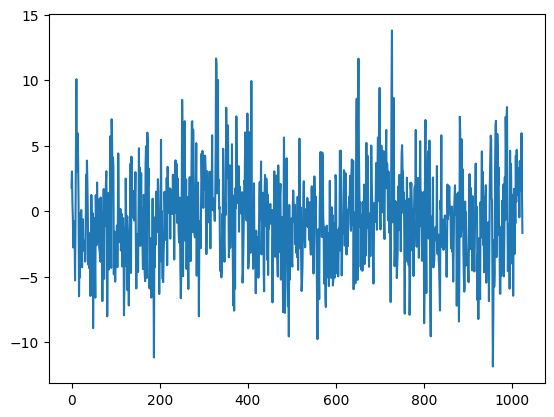

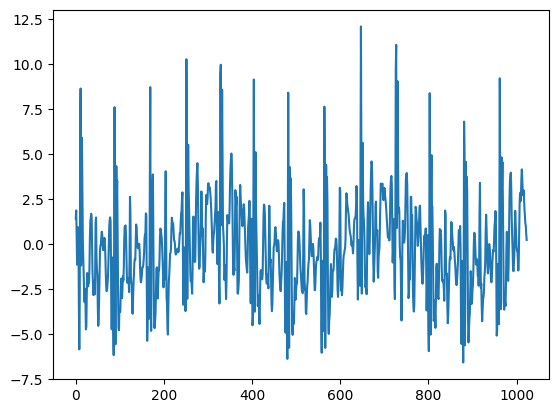

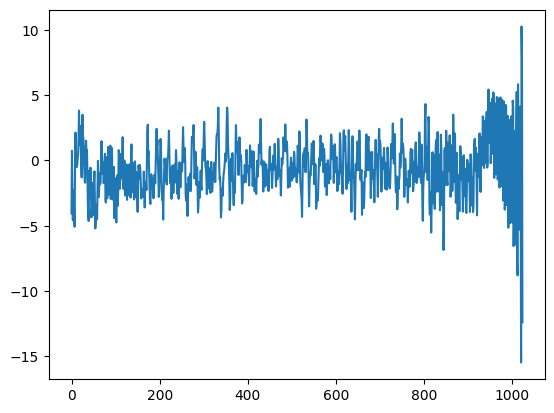

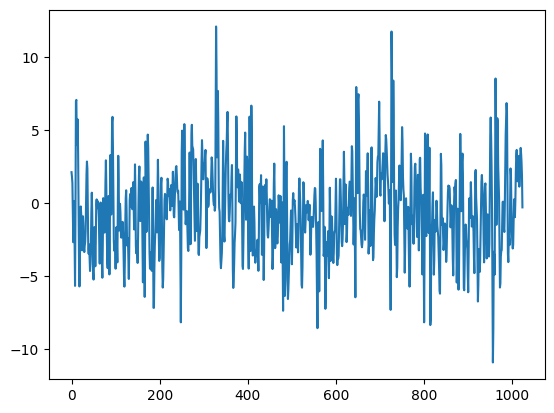

In [50]:
# model = DeNoise2(filters_1=40, filters_2=20).to(device)
model = DeNoise1(layer_size=128).to(device)
model.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))
#model.load_state_dict(model_state)
model.eval()

with torch.no_grad():
    
    noise = test_dataset[256][0].reshape(-1, 1, segment_size_samples).to(device)
    clean = test_dataset[256][1].reshape(-1, 1, segment_size_samples).to(device)

    predicted = model(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

    noise = reverse(noise[0:])
    clean = reverse(clean[0:])
    predicted = reverse(predicted[0:])
    predicted2 = reverse(predicted2[0:])

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print(snr(clean, predicted2))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 0
    time_to = 1024

    plt.plot(range(time_to)[time_from:time_to], noise[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], clean[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted2[time_from:time_to])
    plt.show()
    
    torch.cuda.empty_cache()